## imports

In [77]:
%matplotlib inline

In [78]:
from matplotlib import pyplot as plt

In [79]:
from dateutil.relativedelta import relativedelta

In [80]:
import proplot as plot

In [81]:
import numpy as np
import pandas as pd

In [82]:
import pathlib

In [83]:
import xarray as xr

### define provider and GCM 

In [84]:
provider = 'CDS'

In [85]:
GCM = 'ECMWF'

### var_names are always the same 

In [86]:
var_names = ['T2M','PRECIP']

### output path for the CSV files 

In [87]:
opath = pathlib.Path(f'/home/nicolasf/research/Smart_Ideas/data/GCMs/CSV/{provider}/{GCM}')

### input paths for T2M and PRECIP 

In [88]:
dpath_t2m = pathlib.Path(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/GCMs/processed/hindcasts/{provider}/{GCM}/T2M')

In [89]:
dpath_precip = pathlib.Path(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/GCMs/processed/hindcasts/{provider}/{GCM}/PRECIP')

In [90]:
lfiles_t2m = list(dpath_t2m.glob(f"{GCM}_T2M_seasonal_anomalies_interp_????_??.nc"))

In [91]:
lfiles_precip = list(dpath_precip.glob(f"{GCM}_PRECIP_seasonal_anomalies_interp_????_??.nc"))

In [92]:
lfiles_t2m.sort()

In [93]:
lfiles_precip.sort()

### will need to check if the lists are of the same length

### will loop over each file 

In [94]:
dset_t2m = xr.open_dataset(lfiles_t2m[0])

In [95]:
dset_t2m

<xarray.Dataset>
Dimensions:     (lat: 73, lon: 144, member: 25, step: 3)
Coordinates:
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
    time        datetime64[ns] ...
  * step        (step) int64 3 4 5
    surface     int64 ...
    valid_time  (step) datetime64[ns] ...
    month       int64 ...
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat         (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    t2m         (member, step, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

### need to check whether the dimensions are the same 

In [96]:
dset_t2m.dims

Frozen(SortedKeysDict({'member': 25, 'step': 3, 'lat': 73, 'lon': 144}))

### select latitude range here 

In [97]:
dset_t2m = dset_t2m.sel(step=3, lat=slice(-65,40))

### define the time (init time) and the forecast valid time 

In [98]:
time = pd.to_datetime(dset_t2m.time.data)

In [99]:
forecast_valid_time = time + relativedelta(months=3)

In [100]:
forecast_valid_time

Timestamp('1993-04-01 00:00:00')

### disprecancy between actual forecast valid time and valid time 

In [102]:
dset_t2m.valid_time

<xarray.DataArray 'valid_time' ()>
array('1993-05-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time        datetime64[ns] 1993-01-01
    step        int64 3
    surface     int64 ...
    valid_time  datetime64[ns] 1993-05-01
    month       int64 ...
Attributes:
    standard_name:  time
    long_name:      time

### calculates the ensemble mean here 

In [22]:
ensemble_mean_t2m = dset_t2m.mean('member')

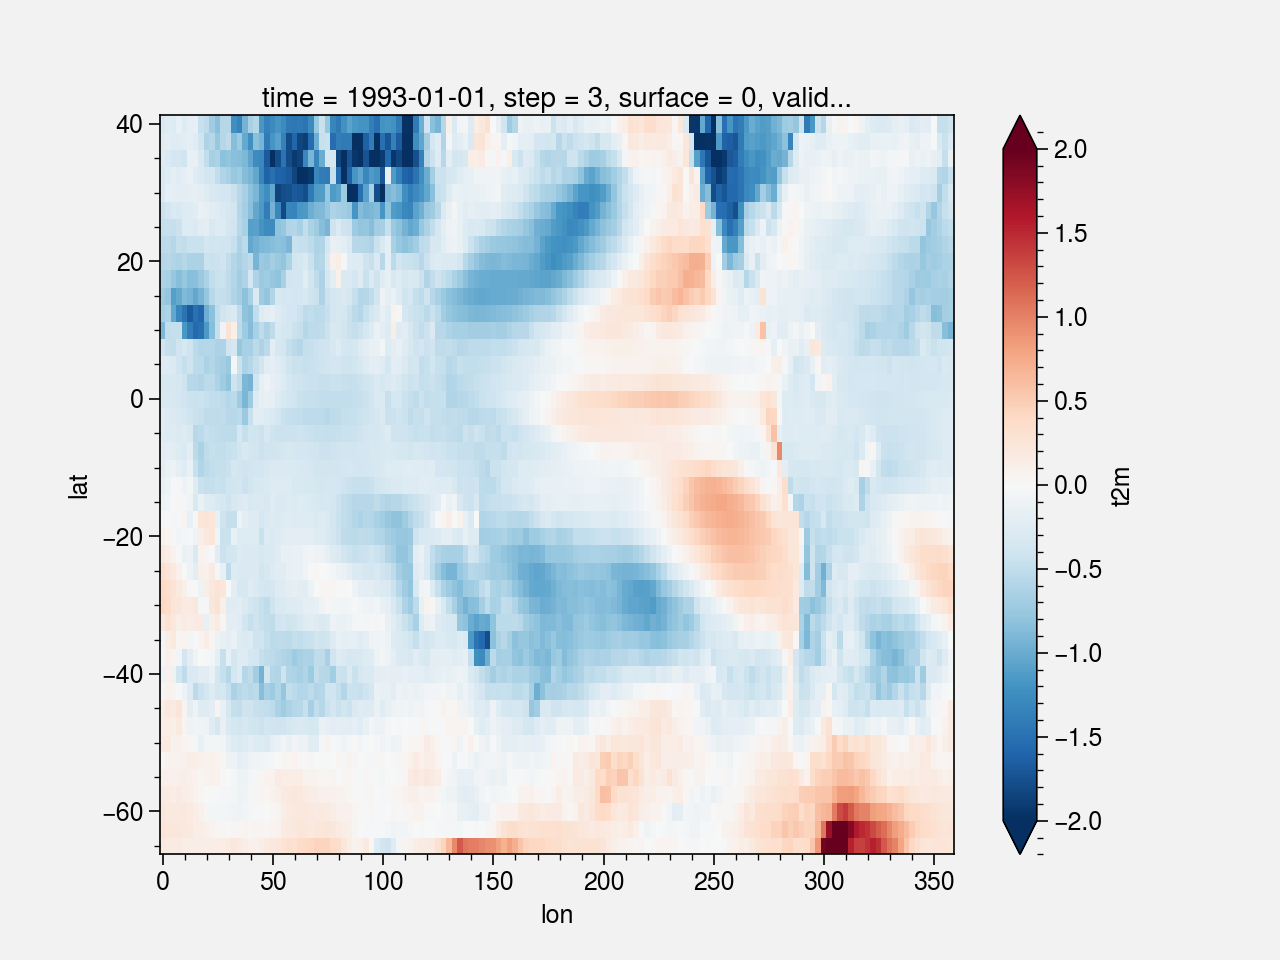

In [23]:
ensemble_mean_t2m['t2m'].plot(vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)

### get the variable with the members of the ensemble 

In [27]:
members = dset_t2m.member.data

In [28]:
members

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

### creates array of indices to calculate 5 ensemble averages from randomly selected members 

In [32]:
inds = np.empty((5,5))

In [33]:
for i in range(5): 
    inds[i,:] = np.random.choice(members, size=5, replace=False)

In [34]:
inds

array([[11.,  1., 10., 18., 20.],
       [14., 13., 10.,  8.,  2.],
       [17., 11.,  0.,  6., 12.],
       [ 4., 22., 15., 10., 14.],
       [ 4., 19., 22., 13., 20.]])

In [35]:
mmeans_t2m = []
for m in range(5): 
    mmeans_t2m.append(dset_t2m.sel(member=inds[m]).mean('member')) 

In [36]:
mmeans_t2m = xr.concat(mmeans_t2m, dim='member')

### comparing the standard deviation of all the ensemble members to the std of the subset of ensemble averages 

In [48]:
import cartopy.crs as ccrs

<xarray.Dataset>
Dimensions:     (lat: 43, lon: 144, member: 5)
Coordinates:
    time        datetime64[ns] 1993-01-01
    month       int64 1
    valid_time  datetime64[ns] 1993-05-01
    step        int64 3
    surface     int64 0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 32.5 35.0 37.5 40.0
Dimensions without coordinates: member
Data variables:
    t2m         (member, lat, lon) float64 0.008777 -0.01967 ... -0.5005 -0.5629

In [63]:
inds

array([[11.,  1., 10., 18., 20.],
       [14., 13., 10.,  8.,  2.],
       [17., 11.,  0.,  6., 12.],
       [ 4., 22., 15., 10., 14.],
       [ 4., 19., 22., 13., 20.]])

In [65]:
dset_t2m.sel(member=inds[0]).std('member')['t2m'].plot(ax=ax)

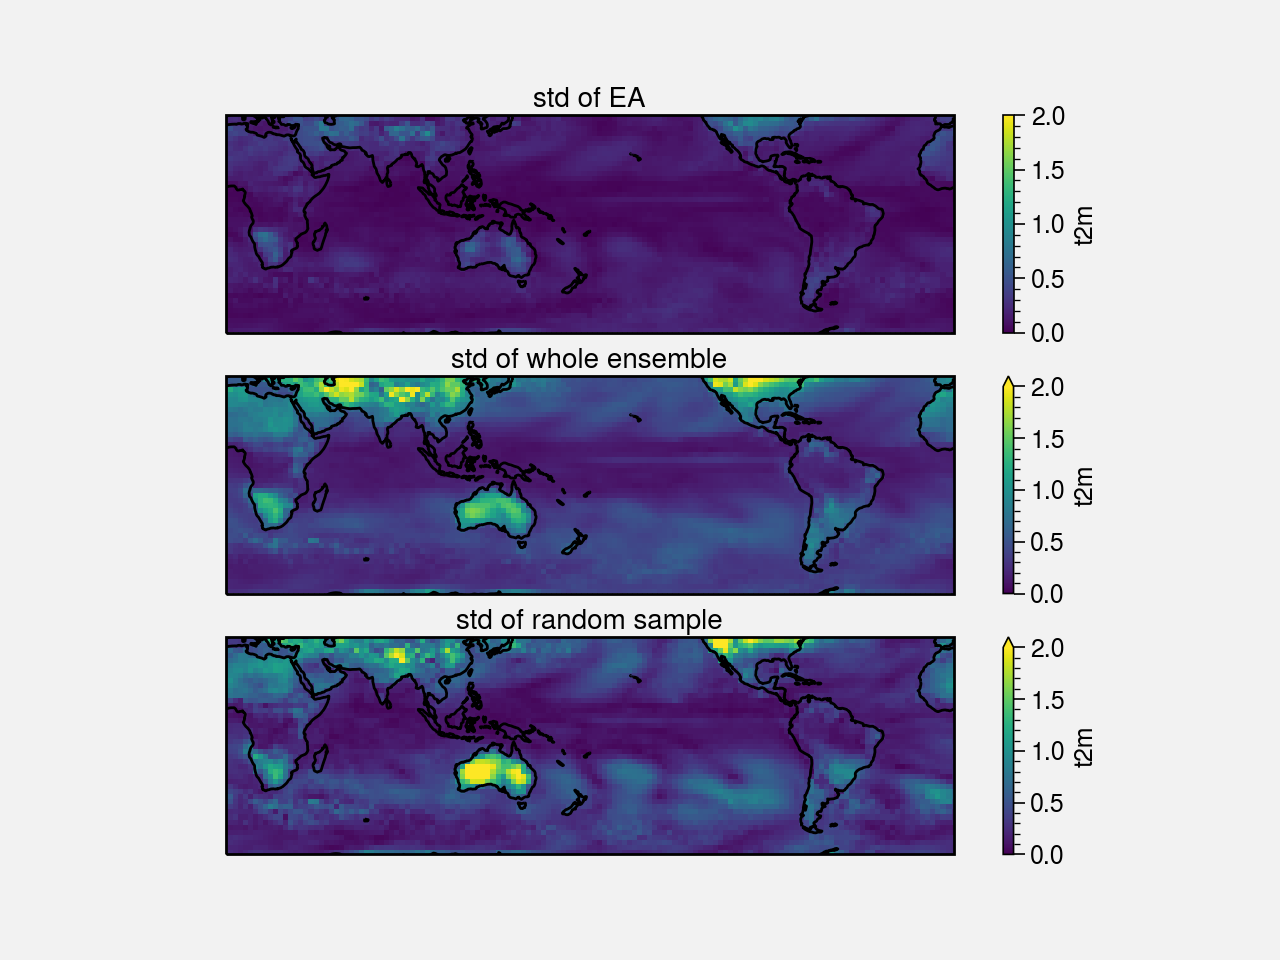

In [67]:
f, axes = plt.subplots(nrows=3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = axes[0]
mmeans_t2m.std('member')['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=2)
ax.coastlines()
ax.set_title('std of EA')

ax = axes[1]
dset_t2m.std('member')['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=2)
ax.coastlines()
ax.set_title('std of whole ensemble')


ax = axes[2]
dset_t2m.sel(member=inds[0]).std('member')['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=2)
ax.coastlines()
ax.set_title('std of random sample')

f.savefig('./STD_ensemble_example.png', dpi=200, bbox_inches='tight')

In [68]:
mmeans_t2m

<xarray.Dataset>
Dimensions:     (lat: 43, lon: 144, member: 5)
Coordinates:
    time        datetime64[ns] 1993-01-01
    month       int64 1
    valid_time  datetime64[ns] 1993-05-01
    step        int64 3
    surface     int64 0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 32.5 35.0 37.5 40.0
Dimensions without coordinates: member
Data variables:
    t2m         (member, lat, lon) float64 0.008777 -0.01967 ... -0.5005 -0.5629

In [69]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/CSV/CDS/ECMWF')

In [76]:
for member in range(5): 
    
    zt2m = mmeans_t2m.sel(member=member).stack(z=('lat', 'lon'))['t2m']
    
    zt2m = zt2m.to_dataframe().T.loc[['t2m']]
    
    zt2m.to_csv(opath / f'Z_{GCM}_ea_{member}_init_{time:%Y_%m}_valid_{forecast_valid_time:%Y_%m}.csv', header=False, index=False)

In [74]:
time

Timestamp('1993-01-01 00:00:00')

NameError: name 'init' is not defined